In [26]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

from matplotlib import pyplot as plt
from PIL import Image
import pandas as pn
import numpy as np

from tqdm import tqdm
import os

In [29]:
tfs = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
path = 'testset/testset/' # пусть до тестовой выборки

In [24]:
train_data = datasets.ImageFolder(root='train/simpsons_dataset', transform=tfs)
number_classes = len(train_data.classes)
path =

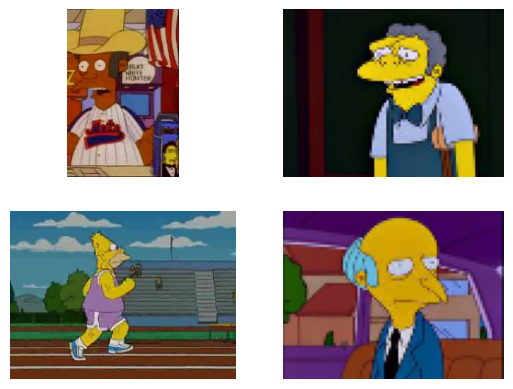

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for ax in axes.flatten():
  random_img = Image.open(path + f'img{np.random.randint(1, 990, 1)[0]}.jpg')
  ax.imshow(random_img)
  ax.axis('off')

In [54]:
class CNN(nn.Module):
  def __init__(self, num_class):
     super().__init__()

     self.num_class = num_class

     self.conv1 = nn.Sequential( # на вход [batch_size, RGB, 224, 224]
         nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2)
     )
     self.conv2 = nn.Sequential( # [bs, 8, 111, 111]
         nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2)
     )
     self.conv3 = nn.Sequential( # [bs, 16, 54, 54]
         nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
         nn.ReLU(),
         nn.MaxPool2d(2),
         nn.Flatten()
     )
     self.liner = nn.Linear(32 * 26 * 26, self.num_class) # [bs, 32, 26, 26]

  def forward(self, x):
    x = self.conv1(x)

    x = self.conv2(x)

    x = self.conv3(x)

    out= self.liner(x)

    return out

In [56]:
model = CNN(number_classes)
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
epochs = 5

g = torch.eye(42)

train = DataLoader(train_data, batch_size=16, shuffle=True)

In [ ]:
for e in range(epochs):
  train_tqdm = tqdm(train, leave=True)

  loss_mean = 0
  lm_count = 0

  for x, y in train_tqdm:
    predict = model(x)

    y = torch.tensor([g[i.item()].tolist() for i in y])

    loss = loss_func(predict, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lm_count += 1
    loss_mean = 1 / lm_count * loss.item() + (1 - 1 / lm_count) * loss_mean

    train_tqdm.set_description(f"Epoch [{e + 1}/{epochs}], loss_mean={loss_mean:.3f}")

torch.save(model.state_dict(), 'model_weights.pth')

Epoch [5/5], loss_mean=0.267: 100%|██████████| 1309/1309 [08:31<00:00,  2.56it/s]


In [58]:
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (liner): Linear(in_features=21632, out_features=42, bias=True)
)

In [63]:
files = os.listdir(path)
Id = []
Expected = []
classes = train_data.classes
for i in files:
  img = tfs(Image.open(path + '/' + i)).unsqueeze(0)
  out = torch.softmax(model(img), dim=1)
  val, predict = torch.max(out, 1)
  name = classes[predict]
  Id.append(i)
  Expected.append(name)

submission = pn.DataFrame({'Id': Id, 'Expected': Expected})

In [72]:
submission['true_id'] = submission['Id'].str.extract(r'img(\d+)\.jpg').astype('int')
submission = submission.set_index('true_id')
submission.sort_index(ascending=True, inplace=True)
submission.head(10)

,Id,Expected
true_id,,
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,ned_flanders
4,img4.jpg,lisa_simpson
5,img5.jpg,principal_skinner
6,img6.jpg,krusty_the_clown
7,img7.jpg,apu_nahasapeemapetilon
8,img8.jpg,principal_skinner


In [73]:
submission.to_csv('answer.csv', index=False)